In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score 
from xgboost.sklearn import XGBClassifier

In [2]:
data_train = pd.read_csv('../input/train.csv')
data_test = pd.read_csv('../input/test.csv')
target = data_train.Survived
data_all = pd.concat([data_train.drop(['Survived'], axis=1), data_test])
for column in data_all.columns:
    print('Column: ', column, ' contain nan: ', data_all[column].isna().any())

Column:  PassengerId  contain nan:  False
Column:  Pclass  contain nan:  False
Column:  Name  contain nan:  False
Column:  Sex  contain nan:  False
Column:  Age  contain nan:  True
Column:  SibSp  contain nan:  False
Column:  Parch  contain nan:  False
Column:  Ticket  contain nan:  False
Column:  Fare  contain nan:  True
Column:  Cabin  contain nan:  True
Column:  Embarked  contain nan:  True


In [3]:
"""
This part use to process Age column in data,
Age data may be nan, we use the NameTitle 
to handle it
"""
def construct_name_title_age_map(data):
    _data = pd.DataFrame.copy(data)
    _data['NameTitle'] = _data.Name.apply(lambda name: re.findall(r'.+, (\w+). .+', name)[0])
    titles = _data.NameTitle.unique()
    title_group = _data.groupby('NameTitle')
    return {title: title_group.get_group(title).Age.mean().astype(int) for title in titles}

def fix_age_using_name_title(data, title_age_map):
    _data = pd.DataFrame.copy(data)
    _data['NameTitle'] = _data.Name.apply(lambda name: re.findall(r'.+, (\w+). .+', name)[0])
    for title, mage in title_age_map.items():
        _data.loc[(_data.Age.isna().any()) & (_data.NameTitle == title), 'Age'] = mage
    return _data

        
# name_title_age_map = construct_name_title_age_map(data_all)
# Following use to fix data's missing Age with mean age of the same title
# tmp = fix_age_using_name_title(data_train, name_title_age_map)
# g = sns.FacetGrid(data_train, col='Survived')
# g = g.map(sns.distplot, "Age")

def convert_age(data):
    dists = range(0, 85, 5)
    def map_age_to_dist(age):
        i = 0
        while i < len(dists) - 1:
            if dists[i+1] > age > dists[i]:
                return i
            i += 1
    _data = pd.DataFrame.copy(data)
    _data.Age = _data.Age.apply(map_age_to_dist)
    return _data

def process_age(data, title_to_age):
    return convert_age(fix_age_using_name_title(data, title_to_age))

In [4]:
"""
This part use to convert Sex to numerical value
"""
def convert_sex(data):
    """Convert Sex"""
    sex_map = {'male': 0, 'female': 1}
    _data = pd.DataFrame.copy(data)
    _data.Sex = _data.Sex.apply(lambda sex: sex_map[sex])
    return _data

def process_sex(data):
    return convert_sex(data)

In [5]:
"""
This part use to convert Embarked to numerical value
Embarked value may be nan, we fix it with mean value of Embarked
"""
def convert_embarked(data):
    """Convert Embarked"""
    dic = {'S': 0, 'C': 1, 'Q': 2}
    _data = pd.DataFrame.copy(data)
    _data.Embarked = _data.Embarked.apply(lambda embarked: dic.get(embarked, embarked))
    return _data

def fix_nan_embarked(data):
    _data = pd.DataFrame.copy(data)
    _data.Embarked = _data.Embarked.apply(lambda embarked: _data.Embarked.mean() if pd.isna(embarked) else embarked)
    return _data

def process_embarked(data):
    return fix_nan_embarked(convert_embarked(data))

In [6]:
"""
This part use to construct new column FamilySize  using
SibSp & Parch columns
"""
def construct_family_size(data):
    """Construct FamilySize"""
    _data = pd.DataFrame.copy(data)
    _data['FamilySize'] = data.SibSp + data.Parch + 1
    return _data

def process_family_size(data):
    return construct_family_size(data)

In [7]:
"""
This part use to process Cabin column
First we build cabin map for convert categorical to numerical
Then we need to handle nan value with Pclass column in data
"""
def extract_cabin_prefix(cabin):
    return cabin.strip()[0] if not pd.isna(cabin) else cabin

def construct_cabin_map(data):
    _data = pd.DataFrame.copy(data)
    cabin = _data.Cabin.apply(extract_cabin_prefix)
    return {  p: i for i, p in enumerate(cabin.unique()) if not pd.isna(p)}

cabin_map = construct_cabin_map(data_all)

def construct_pclass_cabin_map(data):
    _data = pd.DataFrame.copy(data)
    _data.Cabin = _data.Cabin.apply(extract_cabin_prefix)
    group = _data.groupby('Pclass')
    return { pcls: group.get_group(pcls).Cabin.value_counts().index[0] for pcls in  group.groups.keys()}

pclass_cabin_map = construct_pclass_cabin_map(data_all)

def fix_nan_cabin(data, pclass_cabin_map):
    _data = pd.DataFrame.copy(data)
    _data.Cabin = _data.Cabin.apply(extract_cabin_prefix)
    for pclass, mcabin in pclass_cabin_map.items():
        _data.loc[(_data.Cabin.isna().any()) & (_data.Pclass == pclass), 'Cabin'] = mcabin
    return _data

def convert_cabin(data):
    dic = construct_cabin_map(data)
    _data = pd.DataFrame.copy(data)
    _data.Cabin = _data.Cabin.apply(lambda cabin: dic.get(cabin, cabin))
    return _data
    

def process_cabin(data, pclass_to_cabin):
    return convert_cabin(fix_nan_cabin(data, pclass_to_cabin))

1 : 54.17441517027864
2 : 13.35201504211793
3 : 7.967487486548292


/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


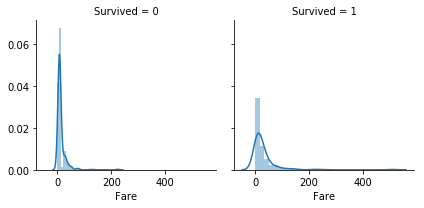

In [8]:
"""
This part use to process Fare column in data  
First we will calculate the mean Fare for each passenger,
we did this cause in data we can found that the Fare of each 
passenger is the total cost of their family, so we would divide 
Fare with FamilySize
Then, we need to fix nan value in Fare, in general, the fare is 
depend on user's Pclass and Cabin, but we can see from above,
Cabin has lots of nan value, so Pclass is better for us
At last, we would convert Fare to dist
"""
def calc_mean_fare(data):
    _data = pd.DataFrame.copy(data)
    _data.Fare = _data.Fare / _data.FamilySize
    return _data

def construct_pclass_fare_map(data):
    _data = calc_mean_fare(data)
    group = _data.groupby('Pclass')
    return {pcls: group.get_group(pcls).Fare.mean() for pcls in group.groups.keys()}

def fix_missing_fare(data, pclass_fare_map):
    """Fix missing price value"""
    _data = calc_mean_fare(data)
    for pcls, mfare in pclass_fare_map.items():
        print(pcls, ':', mfare)
        _data.loc[(_data.Fare.isna().any()) & (_data.Pclass == pcls), 'Fare'] = mfare
    return _data

def convert_fare_to_dist(data):
    dists = [0, 10, 20, 30, 50, 100, 200]
    def map_fare_to_dist(age):
        i = 0
        while i < len(dists) - 1:
            if dists[i+1] > age > dists[i]:
                return i
            i += 1
    _data = pd.DataFrame.copy(data)
    _data.Fare = _data.Fare.apply(map_fare_to_dist)
    return _data
    

tmp_all = construct_family_size(data_all)
tmp_train = construct_family_size(data_train)
pclass_fare_map = construct_pclass_fare_map(tmp_all)
tmp = fix_missing_fare(tmp_train, pclass_fare_map)
g = sns.FacetGrid(tmp, col='Survived')
g = g.map(sns.distplot, "Fare", bins=30)
convert_fare_to_dist(tmp)

def process_fare(data, pclass_to_fare):
    return convert_fare_to_dist(fix_missing_fare(data, pclass_to_fare))

In [9]:
def drop_unnecessary(data):
    return data.drop(['Ticket', 'Name', 'NameTitle', 'SibSp', 'Parch', 'Embarked'], axis=1)

In [10]:
# process data all
All = construct_family_size(data_all)
Name_Title_To_Mean_Age = construct_name_title_age_map(All)
Pclass_To_Mean_Fare = construct_pclass_fare_map(All)
Pclass_To_Most_Cabin = construct_pclass_cabin_map(All)

X_train = process_age(data_train, Name_Title_To_Mean_Age)
X_train = process_sex(X_train)
X_train = process_embarked(X_train)
X_train = process_family_size(X_train)
X_train = process_cabin(X_train, Pclass_To_Most_Cabin)
X_train = process_fare(X_train, Pclass_To_Mean_Fare)
X_train = drop_unnecessary(X_train)
y_train = X_train.Survived
X_train = X_train.drop(['Survived'], axis=1)

1 : 54.17441517027864
2 : 13.35201504211793
3 : 7.967487486548292


In [11]:
xgb_model = XGBClassifier(
    learning_rate =0.008,
     n_estimators=23,
     max_depth=5,
     min_child_weight=1.2,
     gamma=1,
     subsample=0.6,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=8,
     seed=27)
print(cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy'))

[0.8547486  0.82681564 0.82022472 0.80337079 0.84745763]


/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/sklearn/preprocessing/labe

In [12]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1, learning_rate=0.008,
       max_delta_step=0, max_depth=5, min_child_weight=1.2, missing=None,
       n_estimators=23, n_jobs=1, nthread=8, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.6)

In [13]:
X_test = process_age(data_test, Name_Title_To_Mean_Age)
X_test = process_sex(X_test)
X_test = process_embarked(X_test)
X_test = process_family_size(X_test)
X_test = process_cabin(X_test, Pclass_To_Most_Cabin)
X_test = process_fare(X_test, Pclass_To_Mean_Fare)
X_test = drop_unnecessary(X_test)

1 : 54.17441517027864
2 : 13.35201504211793
3 : 7.967487486548292


In [14]:
prediction = xgb_model.predict(X_test)

/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [15]:
submission = pd.DataFrame({
    "PassengerId": X_test["PassengerId"],
    "Survived": prediction
})
submission.to_csv('third_submission.csv', index=False)